In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
import numpy as np
import cv2
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
path = "/kaggle/input/anime-faces/data"

# Loading Dataset

In [2]:
def normalize(x):
    return x / 127.5 - 1

def denormalize(x):
    return (x + 1) * 127.5

In [3]:
ds = tf.keras.utils.image_dataset_from_directory(directory=path, labels=None, 
                                            color_mode='rgb', batch_size=32, 
                                            image_size=(64,64), shuffle=True)
ds = ds.map(normalize, num_parallel_calls=AUTOTUNE)
ds = ds.repeat(None)
ds = ds.prefetch(tf.data.AUTOTUNE)
ds

Found 43102 files belonging to 1 classes.


2022-01-19 11:39:39.604896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 11:39:39.700270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 11:39:39.700999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 11:39:39.703097: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

<PrefetchDataset shapes: (None, 64, 64, 3), types: tf.float32>

2022-01-19 11:39:41.900008: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


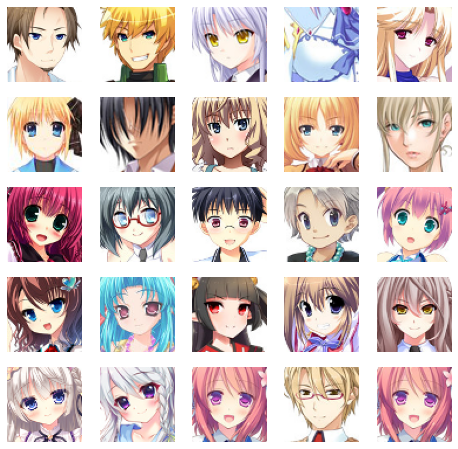

In [4]:
img = next(iter(ds))

_,ax = plt.subplots(5,5, figsize = (8,8))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(denormalize(img)[5*i+j].numpy().astype("uint8"))
        ax[i,j].axis('off')

# Model

In [5]:
#Generator
init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
latent_dims = 100

gen = tf.keras.Sequential([
        tf.keras.layers.Dense(4*4*512, activation='linear', input_shape=(latent_dims,)),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Reshape((4, 4, 512)),

        tf.keras.layers.Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02)),
        tf.keras.layers.BatchNormalization(momentum=0.9, epsilon = 0.00001),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        tf.keras.layers.Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= tf.keras.initializers.TruncatedNormal(stddev=0.02)),
        tf.keras.layers.BatchNormalization(momentum=0.9, epsilon = 0.00001),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        tf.keras.layers.Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= tf.keras.initializers.TruncatedNormal(stddev=0.02)),
        tf.keras.layers.BatchNormalization(momentum=0.9, epsilon = 0.00001),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        tf.keras.layers.Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= tf.keras.initializers.TruncatedNormal(stddev=0.02)),
        tf.keras.layers.BatchNormalization(momentum=0.9, epsilon = 0.00001),
        tf.keras.layers.LeakyReLU(alpha=0.2),

        tf.keras.layers.Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= tf.keras.initializers.TruncatedNormal(stddev=0.02)),
                           
        tf.keras.layers.Activation("tanh")
])
gen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         4194816   
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       2

In [6]:
#Discriminator
input_layer = tf.keras.Input(shape=(64, 64, 3))
x = tf.keras.layers.Conv2D(128, (3,3), padding='same')(input_layer)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(128, (3,3), padding='same')(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(128, (3,3), padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), padding='same')(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(128, (3,3), padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

disc = tf.keras.models.Model(input_layer,output_layer)
disc.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 128)       512   

# Losses and optimizers

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)

# Training

In [8]:
!mkdir images
noise_dims = 100
epoch = 600
batch_size = 32

In [9]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dims])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        new_img = gen(noise, training=True)

        real = disc(images, training=True)
        fake = disc(new_img, training=True)
        
        gen_loss = generator_loss(fake)
        disc_loss = discriminator_loss(real, fake)
        
    gen_gradients = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_gradients, gen.trainable_variables))

    disc_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(disc_gradients, disc.trainable_variables))
    
    return gen_loss,disc_loss

In [10]:
counter = 0
gen_loss_save = []
disc_loss_save = []
prediction_noise = tf.random.normal([1, 100])

for epochs in range(epoch):
    
    for images in ds.take(200):
        gen_loss, disc_loss = train_step(images)
        gen_loss_save.append(gen_loss)
        disc_loss_save.append(disc_loss)
    
    generated_img = gen.predict(prediction_noise)
    tf.keras.utils.save_img(f"/kaggle/working/images/{counter}.png", tf.squeeze(generated_img,axis=0))
    counter += 1
    
    if epochs%100==0:
        print(f"Epoch: {epochs}  ||  Generator_Loss: {gen_loss:.3f}  ||  Discriminator_loss: {disc_loss:.3f}")

2022-01-19 11:39:48.492492: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Epoch: 0  ||  Generator_Loss: 2.693  ||  Discriminator_loss: 0.332
Epoch: 100  ||  Generator_Loss: 4.872  ||  Discriminator_loss: 0.136
Epoch: 200  ||  Generator_Loss: 4.386  ||  Discriminator_loss: 0.591
Epoch: 300  ||  Generator_Loss: 10.068  ||  Discriminator_loss: 0.006
Epoch: 400  ||  Generator_Loss: 8.827  ||  Discriminator_loss: 0.125
Epoch: 500  ||  Generator_Loss: 9.123  ||  Discriminator_loss: 0.075


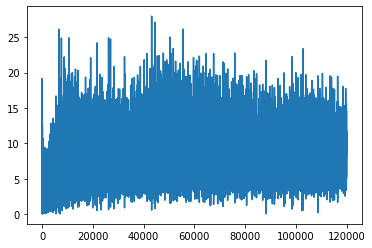

In [11]:
plt.plot(gen_loss_save)
plt.show()

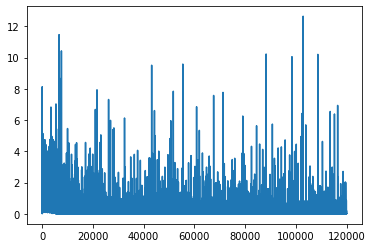

In [12]:
plt.plot(disc_loss_save)
plt.show()

In [13]:
!mkdir model
gen.save("/kaggle/working/gen.h5")
gen.save("/kaggle/working/model/",save_format='tf')

2022-01-19 14:25:52.661443: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
